# 2024 COMP90042 Project
*Make sure you change the file name with your group id.*

# Readme

## Project Overview

This project involves training, development, and testing of models using specific data files. For the successful execution of the code, all data files must be placed in the specified directory on Google Drive.

## Data Files

The following data files are required for the project:

- **Training Claims Data**: `train-claims.json`
- **Development Claims Data**: `dev-claims.json`
- **Test Claims Data (Unlabelled)**: `test-claims-unlabelled.json`
- **Development Claims Baseline Data**: `dev-claims-baseline.json`
- **Evidence Data**: `evidence.json`

## Directory Structure

Ensure that the directory structure is as follows:

```
/content/drive/MyDrive/data/
│
├── train-claims.json
├── dev-claims.json
├── test-claims-unlabelled.json
├── dev-claims-baseline.json
└── evidence.json
```


## Instructions

1. **Place the JSON Files**: Ensure that all the required JSON files are located in the specified directory (`/content/drive/MyDrive/data/`).

2. **Adjust Path**: Adjust the `os.chdir` in the notebook to point to the correct path.

3. **Run the Notebook**: Change the runtime to google colab `GPU`. Click on `Run All` to run the entire code.

By following the above structure and instructions, the code will be able to locate and load the required data files without any issues.



# 1.DataSet Processing
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.chdir('drive/MyDrive/data') # Change the file path here.
!ls


Mounted at /content/drive
dev-claims-baseline.json   processed_dev_claims.csv
dev-claims.json		   processed_evidence.csv
dev-eval-output.json	   processed_test_claims.csv
eval.py			   processed_train_claims.csv
evidence.json		   __pycache__
evidence.md		   README.md
Final_NLP_Aadesh_v1.ipynb  test-claims-unlabelled.json
labels.json		   test.ipynb
myenv			   train-claims.json
predictions.json	   V2_AADESH_NLP_FINAL_ASSIGNMENT_BERT_MO_V1.ipynb


In this section, we perform the following steps:

1. **Load JSON Data**: Load the JSON files containing the training, development, test, and evidence data.

2. **Convert JSON to Pandas DataFrame**: Convert the loaded JSON data into Pandas DataFrames for easier data inspection and manipulation.

3. **Analyze Class Balance**: Check the distribution of classes (labels) in the training and development data.

4. **Visualize Data**:
   - Create a bar plot to visualize the distribution of labels in the training and development data.
   - Analyze the distribution of evidence text lengths by creating a histogram plot.



Class Distribution in Train Data:
claim_label
SUPPORTS           519
NOT_ENOUGH_INFO    386
REFUTES            199
DISPUTED           124
Name: count, dtype: int64

Class Distribution in Dev Data:
claim_label
SUPPORTS           68
NOT_ENOUGH_INFO    41
REFUTES            27
DISPUTED           18
Name: count, dtype: int64


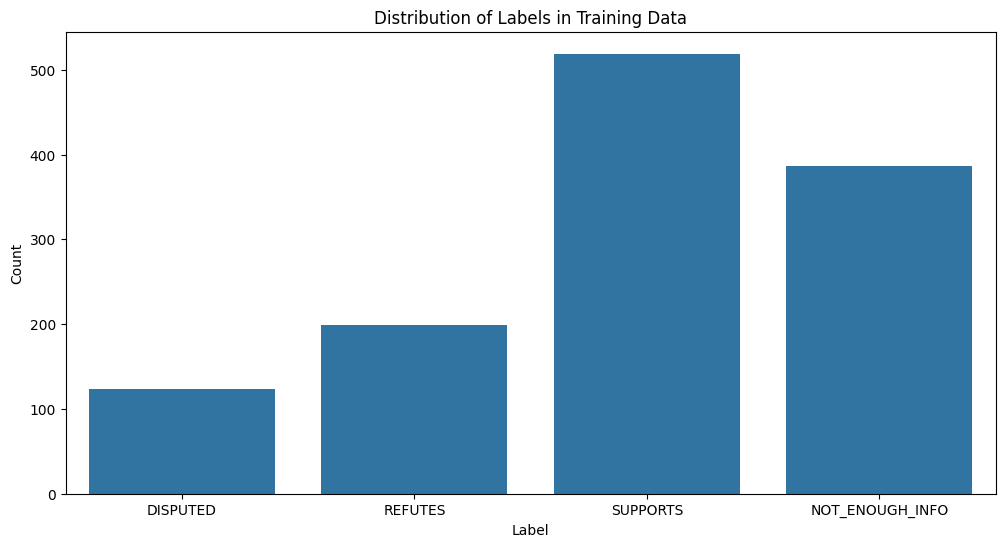

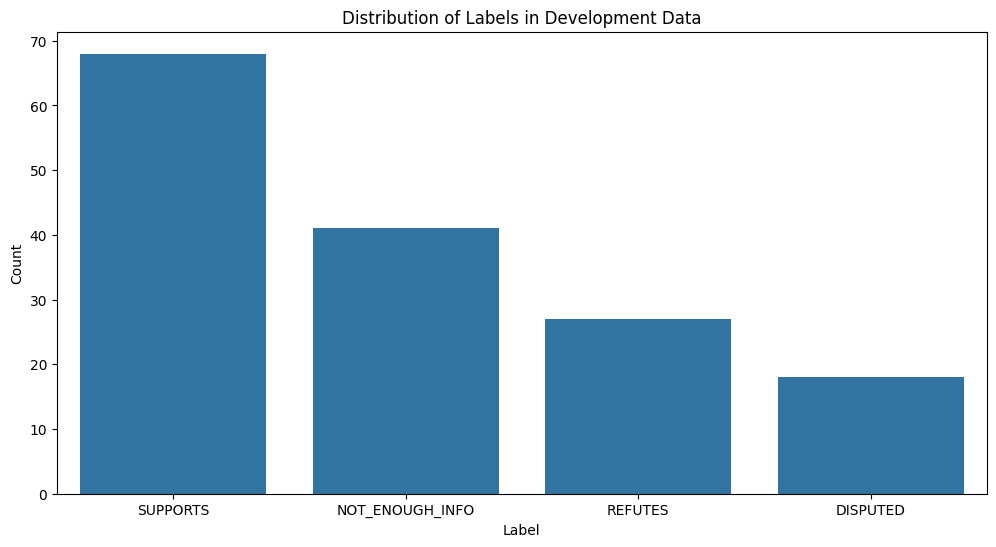

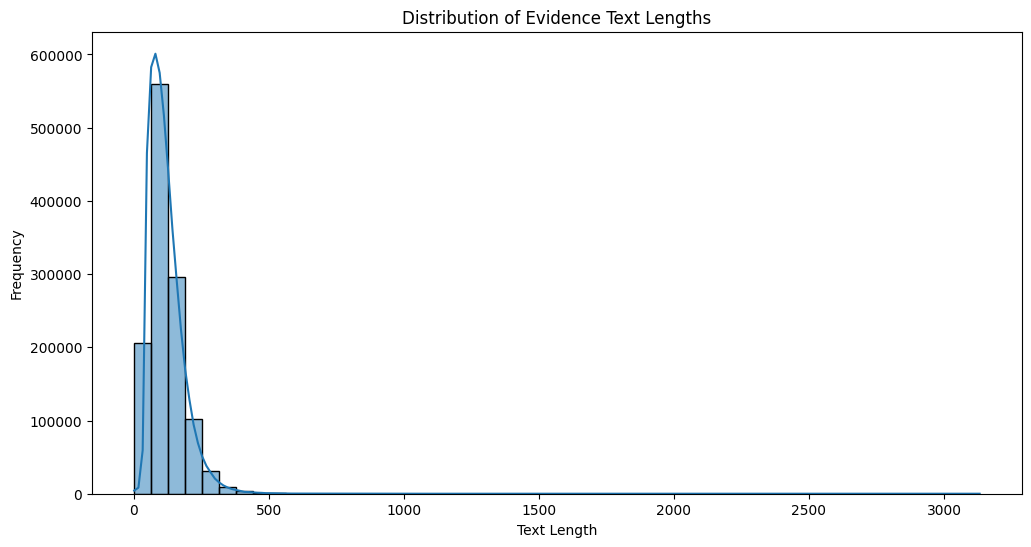

In [2]:
# Data loading and study
import nltk
import json
import pandas as pd
import torch
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Load the JSON files
with open('train-claims.json', 'r') as f:
    train_data = json.load(f)
with open('dev-claims.json', 'r') as f:
    dev_data = json.load(f)
with open('test-claims-unlabelled.json', 'r') as f:
    test_data = json.load(f)
with open('evidence.json', 'r') as f:
        evidence_data = json.load(f)
with open('dev-claims-baseline.json', 'r') as f:
        dev_baseline_data = json.load(f)

# Get cpu, gpu or mps device for training.
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

# Convert to DataFrame to inspect
train_df = pd.DataFrame.from_dict(train_data, orient='index')
dev_df = pd.DataFrame.from_dict(dev_data, orient='index')
test_df = pd.DataFrame.from_dict(test_data, orient='index')
evidence_df = pd.DataFrame.from_dict(evidence_data, orient='index', columns=['evidence_text'])

# 3. Balance of Classes
if 'claim_label' in train_df.columns:
    print("\nClass Distribution in Train Data:")
    print(train_df['claim_label'].value_counts())

if 'claim_label' in dev_df.columns:
    print("\nClass Distribution in Dev Data:")
    print(dev_df['claim_label'].value_counts())

# 4. Visualizations
# Distribution of Claims
plt.figure(figsize=(12, 6))
sns.countplot(x='claim_label', data=train_df)
plt.title('Distribution of Labels in Training Data')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x='claim_label', data=dev_df)
plt.title('Distribution of Labels in Development Data')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Evidence Text Length Distribution
evidence_df['text_length'] = evidence_df['evidence_text'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(evidence_df['text_length'], bins=50, kde=True)
plt.title('Distribution of Evidence Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


 Preprocesses text data from claims and evidence files for further analysis or machine learning tasks. It performs the following steps:

1. **Import Libraries**: Imports necessary libraries (`re`, `nltk`, `pandas`) and downloads NLTK resources for stopwords, tokenization, and lemmatization.
2. **Define Contractions Dictionary**: A dictionary to expand common English contractions (e.g., "don't" to "do not").
3. **Preprocess Function**: The `preprocess_text` function:
   - Converts text to lowercase.
   - Expands contractions.
   - Tokenizes the text.
   - Removes stopwords and lemmatizes the words.
4. **Apply Preprocessing**: Applies the `preprocess_text` function to the `claim_text` and `evidence_text` columns of the DataFrames, storing the results in new columns (`processed_claim` and `processed_evidence`).
5. **Save to CSV**: Saves the processed DataFrames to CSV files. (optional)



In [3]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have",
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

def preprocess_text(sent):
    sent = sent.lower()  # case-folding
    for word, new_word in contraction_dict.items():
        sent = sent.replace(word, new_word)  # dealing with contractions
    sent = re.sub(r'[^a-zA-Z0-9\s]', '', sent)  # removing non-alphanumeric characters
    words = word_tokenize(sent)  # tokenization
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    sent_list = lemmatized_words
    return ' '.join(sent_list)

# Preprocess the text and store in CSV files
train_df['processed_claim'] = train_df['claim_text'].apply(preprocess_text)
dev_df['processed_claim'] = dev_df['claim_text'].apply(preprocess_text)
test_df['processed_claim'] = test_df['claim_text'].apply(preprocess_text)
evidence_df['processed_evidence'] = evidence_df['evidence_text'].apply(preprocess_text)

# Write the dataframes to CSV files
train_df.to_csv('train_df.csv', index=True)
dev_df.to_csv('dev_df.csv', index=True)
test_df.to_csv('test_df.csv', index=True)
evidence_df.to_csv('evidence_df.csv', index=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [4]:
train_lens = [len(s.split()) for s in list(train_df['processed_claim'])]
mode_train_len = pd.Series(train_lens).mode()
print(f"The most frequent sentence length in the train dataset is: {mode_train_len.values[0]:.2f}")
evidence_lens = [len(s.split()) for s in list(evidence_df['processed_evidence'])]
mode_evidence_len = pd.Series(evidence_lens).mode()
print(f"The most frequent sentence length in the evidence dataset is: {mode_evidence_len.values[0]:.2f}")

The most frequent sentence length in the train dataset is: 9.00
The most frequent sentence length in the evidence dataset is: 8.00


# 2. Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

# Compute Jaccard Similarity and Filter Evidences

In this section, we:

1. **Define Jaccard Similarity Function**: Define a function to compute the Jaccard similarity between two input texts. Splits each text into sets of words. Calculates the intersection and union of these sets. Returns the ratio of the intersection size to the union size, representing the similarity.

2. **Filter Evidences using Jaccard Similarity**: Define a function to filter the top `k` (default = 10) evidences with the highest Jaccard similarity scores for a given claim.

3. **Compute Similarities between Claims and Evidences**: Define a function to compute the similarities between processed claims and processed evidences using the Jaccard similarity filter.

4. **Create New DataFrames with Filtered Evidences**: Define a function to create new DataFrames with the claim text, processed claim, and the filtered evidence IDs based on the computed similarities.

5. **Compute Similarities and Create New DataFrames**: Compute the similarities between claims and evidences for the development and test datasets, and create new DataFrames with the filtered evidences.


In [5]:
# Compute jaccard similarity between two texts
def jaccard_similarity(s1, s2):
    """
    Compute the Jaccard similarity between two texts.

    Args:
        s1 (str): The first text.
        s2 (str): The second text.

    Returns:
        float: The Jaccard similarity between the two texts.
    """
    set1 = set(s1.split())
    set2 = set(s2.split())
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    similarity = len(intersection) / len(union)
    return similarity

# Use Jaccard similarity to filter evidences
def jaccard_filter(claim, evidences, k=10):
    """
    Use Jaccard similarity to filter evidences for a given claim.

    Args:
        claim (str): The claim text.
        evidences (list): A list of evidence texts.
        k (int, optional): The number of top evidences to return. Defaults to 10.

    Returns:
        list: A list of tuples containing the indices and Jaccard similarities
              of the top k evidences, sorted in descending order by similarity.
    """
    res = []
    for i, ev in enumerate(evidences):
        res.append((i, jaccard_similarity(claim, ev)))
    return sorted(res, key = lambda x: x[1], reverse=True)[:k]

In [6]:
# Compute Jaccard similarity between processed claims and processed evidences
def compute_similarities(df, evidence_df,k):
    """
    Compute Jaccard similarity between processed claims and processed evidences.

    Args:
        df (pandas.DataFrame): The DataFrame containing the claims.
        evidence_df (pandas.DataFrame): The DataFrame containing the evidences.
        k (int): The number of top evidences to return for each claim.

    Returns:
        list: A list of lists, where each inner list contains the indices and
              Jaccard similarities of the top k evidences for the corresponding claim.
    """
    similarities = []
    for i, claim in enumerate(df['processed_claim']):
        print(f"Processing claim {i}")
        similarities.append(jaccard_filter(claim, evidence_df['processed_evidence'], k))
    return similarities

# Create a new dataframe with the necessary columns
def create_new_df(df, similarities):
    """
    Create a new DataFrame with the necessary columns.

    Args:
        df (pandas.DataFrame): The original DataFrame containing the claims.
        similarities (list): A list of lists, where each inner list contains the indices and
                             Jaccard similarities of the top k evidences for the corresponding claim.

    Returns:
        pandas.DataFrame: A new DataFrame with columns 'claim_text', 'evidences', and 'processed_claim'.
    """
    new_df = pd.DataFrame(columns=['claim_text', 'evidences', 'processed_claim'])
    for i, claim in enumerate(df['claim_text']):
        predicted_evidence_ids = [evidence_df.index[idx] for idx, _ in similarities[i]]
        processed_claim = df.iloc[i]['processed_claim']
        new_row = pd.DataFrame({'claim_text': [claim], 'evidences': [predicted_evidence_ids], 'processed_claim': [processed_claim]},index=[df.index[i]])
        new_df = pd.concat([new_df, new_row], ignore_index=False)
    return new_df

In [7]:
k=10 # Select the number of evidences to be retreived per claim
# Compute similarities and create new dataframes for dev and test
dev_claim_evidence_similarities = compute_similarities(dev_df, evidence_df, k)
dev_new_df = create_new_df(dev_df, dev_claim_evidence_similarities)
test_claim_evidence_similarities = compute_similarities(test_df, evidence_df, k)
test_new_df = create_new_df(test_df, test_claim_evidence_similarities)

Processing claim 0
Processing claim 1
Processing claim 2
Processing claim 3
Processing claim 4
Processing claim 5
Processing claim 6
Processing claim 7
Processing claim 8
Processing claim 9
Processing claim 10
Processing claim 11
Processing claim 12
Processing claim 13
Processing claim 14
Processing claim 15
Processing claim 16
Processing claim 17
Processing claim 18
Processing claim 19
Processing claim 20
Processing claim 21
Processing claim 22
Processing claim 23
Processing claim 24
Processing claim 25
Processing claim 26
Processing claim 27
Processing claim 28
Processing claim 29
Processing claim 30
Processing claim 31
Processing claim 32
Processing claim 33
Processing claim 34
Processing claim 35
Processing claim 36
Processing claim 37
Processing claim 38
Processing claim 39
Processing claim 40
Processing claim 41
Processing claim 42
Processing claim 43
Processing claim 44
Processing claim 45
Processing claim 46
Processing claim 47
Processing claim 48
Processing claim 49
Processing

In [8]:
# Creating dataframe for futher processing
def create_new_dataframe(df, evidence_df, train=True):
    """
    Create a new DataFrame with the following structure:
    - claim_id
    - claim_text
    - processed_claim
    - claim_label (if train=True)
    - evidence_id
    - processed_evidence

    Args:
        df (pandas.DataFrame): The DataFrame containing the claims and evidences.
        evidence_df (pandas.DataFrame): The DataFrame containing the processed evidences.
        train (bool, optional): Whether the DataFrame is for training or evaluation. Defaults to True.

    Returns:
        pandas.DataFrame: A new DataFrame with the specified structure.
    """
    data = []
    for idx, row in df.iterrows():
        claim_id = idx
        claim_text = row['claim_text']
        processed_claim = row['processed_claim']
        if train:
          claim_label = row['claim_label']
        evidence_ids = row['evidences']

        for evidence_id in evidence_ids:
            processed_evidence = evidence_df.loc[evidence_id, 'processed_evidence']
            if claim_text and processed_claim and processed_evidence:
              if train:
                data.append({
                    'claim_id': claim_id,
                    'claim_text': claim_text,
                    'processed_claim': processed_claim,
                    'claim_label': claim_label,
                    'evidence_id': evidence_id,
                    'processed_evidence': processed_evidence,
                })
              else:
                    data.append({
                    'claim_id': claim_id,
                    'claim_text': claim_text,
                    'processed_claim': processed_claim,
                    'evidence_id': evidence_id,
                    'processed_evidence': processed_evidence,
                })

    new_df = pd.DataFrame(data)
    return new_df

# Create the training, development, and evaluation DataFrames
training_df = create_new_dataframe(train_df, evidence_df)
development_df = create_new_dataframe(dev_df, evidence_df)
development_eval_df = create_new_dataframe(dev_new_df, evidence_df, False)
test_eval_df = create_new_dataframe(test_new_df, evidence_df, False)

# Write the dataframes to CSV files
# training_df.to_csv('training_df.csv', index=True)
# development_df.to_csv('development_df.csv', index=True)
# development_eval_df.to_csv('development_eval_df.csv', index=True)
# test_eval_df.to_csv('test_eval_df.csv', index=True)

In [9]:
# Sample dataframe
training_df

,claim_id,claim_text,processed_claim,claim_label,evidence_id,processed_evidence
0,claim-1937,Not only is there no scientific evidence that ...,scientific evidence co2 pollutant higher co2 c...,DISPUTED,evidence-442946,high concentration 100 time atmospheric concen...
1,claim-1937,Not only is there no scientific evidence that ...,scientific evidence co2 pollutant higher co2 c...,DISPUTED,evidence-1194317,plant grow much 50 percent faster concentratio...
2,claim-1937,Not only is there no scientific evidence that ...,scientific evidence co2 pollutant higher co2 c...,DISPUTED,evidence-12171,higher carbon dioxide concentration favourably...
3,claim-126,El Niño drove record highs in global temperatu...,el nio drove record high global temperature su...,REFUTES,evidence-338219,climate change due natural force human activit...
4,claim-126,El Niño drove record highs in global temperatu...,el nio drove record high global temperature su...,REFUTES,evidence-1127398,acceleration due mostly humancaused global war...
...,...,...,...,...,...,...
4117,claim-502,But abnormal temperature spikes in February an...,abnormal temperature spike february earlier mo...,NOT_ENOUGH_INFO,evidence-583187,coastline see significantly mild temperature c...
4118,claim-3093,Sending oscillating microwaves from an antenna...,sending oscillating microwave antenna inside v...,SUPPORTS,evidence-971105,dielectric heating also known electronic heati...
4119,claim-3093,Sending oscillating microwaves from an antenna...,sending oscillating microwave antenna inside v...,SUPPORTS,evidence-457769,example absorption emission radio wave antenna...
4120,claim-3093,Sending oscillating microwaves from an antenna...,sending oscillating microwave antenna inside v...,SUPPORTS,evidence-298971,water fat substance food absorb energy microwa...


In [10]:
from collections import Counter

def create_vocabulary(sentences, pad_token='<pad>'):
    """
    Create a vocabulary dictionary from a list of sentences.

    Args:
        sentences (list): A list of sentences.
        pad_token (str): The padding token to add to the vocabulary.

    Returns:
        vocab (dict): A dictionary mapping words to their indices.
    """
    vocab = Counter()
    for sentence in sentences:
        vocab.update(sentence.split())
    vocab = dict(vocab.most_common())
    vocab[pad_token] = 0
    return vocab

evidence_processed_list = list(evidence_df['processed_evidence'])
evidence_vocab = create_vocabulary(evidence_processed_list)

# Set the maximum sentence length
max_len = 12

# Tokenize and convert training data to token IDs
train_claim_token_ids = [[evidence_vocab.get(word, evidence_vocab['<pad>']) for word in sentence.split()[:max_len]] for sentence in list(training_df['processed_claim'])]
train_evidence_token_ids = [[evidence_vocab.get(word, evidence_vocab['<pad>']) for word in sentence.split()[:max_len]] for sentence in list(training_df['processed_evidence'])]

# Tokenize and convert development data to token IDs
dev_claim_token_ids = [[evidence_vocab.get(word, evidence_vocab['<pad>']) for word in sentence.split()[:max_len]] for sentence in list(development_df['processed_claim'])]
dev_evidence_token_ids = [[evidence_vocab.get(word, evidence_vocab['<pad>']) for word in sentence.split()[:max_len]] for sentence in list(development_df['processed_evidence'])]

# Tokenize and convert development evaluation data to token IDs
dev_eval_claim_token_ids = [[evidence_vocab.get(word, evidence_vocab['<pad>']) for word in sentence.split()[:max_len]] for sentence in list(development_eval_df['processed_claim'])]
dev_eval_evidence_token_ids = [[evidence_vocab.get(word, evidence_vocab['<pad>']) for word in sentence.split()[:max_len]] for sentence in list(development_eval_df['processed_evidence'])]

# Tokenize and convert evidence data to token IDs
evidence_token_ids = [[evidence_vocab.get(word, evidence_vocab['<pad>']) for word in sentence.split()[:max_len]] for sentence in list(evidence_df['processed_evidence'])]

# Tokenize and convert test evaluation data to token IDs
test_eval_claim_token_ids = [[evidence_vocab.get(word, evidence_vocab['<pad>']) for word in sentence.split()[:max_len]] for sentence in list(test_eval_df['processed_claim'])]
test_eval_evidence_token_ids = [[evidence_vocab.get(word, evidence_vocab['<pad>']) for word in sentence.split()[:max_len]] for sentence in list(test_eval_df['processed_evidence'])]

In [11]:
# Creating data loaders for the claim classification
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import random

label_to_index = {'SUPPORTS': 0, 'REFUTES': 1, 'NOT_ENOUGH_INFO': 2, 'DISPUTED': 3}

class FactCheckingDataset(Dataset):
    """
    Custom PyTorch dataset for fact-checking.

    Args:
        claim_token_ids (list): A list of lists containing token IDs for claims.
        evidence_token_ids (list): A list of lists containing token IDs for evidences.
        labels (pandas.Series): A pandas Series containing the labels for each claim.
    """
    def __init__(self, claim_token_ids, evidence_token_ids, labels):
        self.claim_token_ids = claim_token_ids
        self.evidence_token_ids = evidence_token_ids
        self.labels = labels.apply(lambda x: label_to_index[x]).values

    def __len__(self):
        return len(self.claim_token_ids)

    def __getitem__(self, idx):
        return self.claim_token_ids[idx], self.evidence_token_ids[idx], self.labels[idx]

def collate_fn(batch, is_train=True):
    """
    Custom collate function for the fact-checking dataset.

    Args:
        batch (list): A list of tuples containing (claim_token_ids, evidence_token_ids, label).
        is_train (bool, optional): Whether the collate function is called during training or evaluation. Defaults to True.

    Returns:
        tuple: A tuple containing (claim_tensors, evidence_tensors, labels).
    """
    claims, evidence, labels = zip(*batch)

    # Find the maximum length of claim and evidence sequences
    max_claim_len = max(len(c) for c in claims)
    max_evidence_len = max(len(e) for e in evidence)

    # Pad the claim and evidence sequences to the maximum length
    claim_tensors = pad_sequence([torch.tensor(c) for c in claims], batch_first=True, padding_value=0)
    evidence_tensors = pad_sequence([torch.tensor(e) for e in evidence], batch_first=True, padding_value=0)

    # Ensure that the claim and evidence tensors have the same length
    if max_claim_len > max_evidence_len:
        evidence_tensors = torch.nn.functional.pad(evidence_tensors, (0, max_claim_len - max_evidence_len), value=0)
    elif max_evidence_len > max_claim_len:
        claim_tensors = torch.nn.functional.pad(claim_tensors, (0, max_evidence_len - max_claim_len), value=0)

    # Randomly mask words in the training dataloader
    if is_train:
        claim_tensors = _mask_tokens(claim_tensors)
        evidence_tensors = _mask_tokens(evidence_tensors)

    labels = torch.tensor(labels)

    return claim_tensors, evidence_tensors, labels

def _mask_tokens(input_ids, mask_prob=0.1):
    """
    Randomly mask tokens in the input_ids tensor.

    Args:
        input_ids (torch.Tensor): A tensor containing token IDs.
        mask_prob (float, optional): The probability of masking a token. Defaults to 0.1.

    Returns:
        torch.Tensor: A tensor with randomly masked tokens.
    """
    batch_size, seq_length = input_ids.size()
    mask = torch.zeros(batch_size, seq_length, dtype=torch.bool)
    for i in range(batch_size):
        for j in range(seq_length):
            if random.random() < mask_prob:
                mask[i, j] = True

    masked_input_ids = input_ids.clone()
    masked_input_ids[mask] = 0  # 0 is the index of the [MASK] token
    return masked_input_ids

# Create the datasets
train_dataset = FactCheckingDataset(train_claim_token_ids, train_evidence_token_ids, training_df['claim_label'])
dev_dataset = FactCheckingDataset(dev_claim_token_ids, dev_evidence_token_ids, development_df['claim_label'])

# Create the dataloaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda batch: collate_fn(batch, is_train=True))
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda batch: collate_fn(batch, is_train=False))

In [12]:
# Model defintion
import math
import torch.nn as nn
import torch.nn.functional as F
import math
torch.cuda.empty_cache()
import gc         # garbage collect library
gc.collect()

class PositionalEncoding(nn.Module):
    """
    Positional encoding module for the Transformer model.

    Args:
        d_model (int): The dimension of the input embeddings.
        dropout (float, optional): The dropout rate. Defaults to 0.1.
        max_len (int, optional): The maximum length of the input sequence. Defaults to 5000.
    """
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class FeatureExtractor(nn.Module):
    """
    Feature extractor module for the fact-checking model.

    Args:
        vocab_size (int): The size of the vocabulary.
        embedding_dim (int): The dimension of the input embeddings.
        num_layers (int): The number of Transformer encoder layers.
        num_heads (int): The number of attention heads in the Transformer encoder.
        dim_feedforward (int): The dimension of the feedforward network in the Transformer encoder.
    """
    def __init__(self, vocab_size, embedding_dim, num_layers, num_heads, dim_feedforward):
        super(FeatureExtractor, self).__init__()

        # Embedding
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.pos_encoding = PositionalEncoding(embedding_dim)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dim_feedforward=dim_feedforward, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)

    def forward(self, input_tensors):
        input_tensors = input_tensors.to(torch.long)

        # Embedding and Transformer
        embeddings = self.embedding(input_tensors)
        embeddings = self.pos_encoding(embeddings)
        output = self.transformer(embeddings)
        final_hidden = F.avg_pool1d(output.transpose(1, 2), kernel_size=output.size(1)).squeeze(2)
        return final_hidden

class FactCheckingModel(nn.Module):
    """
    Fact-checking model for claim classification.

    Args:
        feature_extractor (nn.Module): The feature extractor module.
        embedding_dim (int): The dimension of the input embeddings.
        num_labels (int): The number of output labels.
    """
    def __init__(self, feature_extractor, embedding_dim, num_labels):
        super(FactCheckingModel, self).__init__()
        self.feature_extractor = feature_extractor

        # Fully Connected Layers
        self.fc1 = nn.Linear(3 * embedding_dim, num_labels)
        self.bn1 = nn.BatchNorm1d(num_labels)

    def forward(self, claim_tensors, evidence_tensors):
        claim_final_hidden = self.feature_extractor(claim_tensors)
        evidence_final_hidden = self.feature_extractor(evidence_tensors)

        # Concatenation and absolute difference
        combined_hidden = torch.cat((claim_final_hidden, evidence_final_hidden, torch.abs(claim_final_hidden - evidence_final_hidden)), dim=1)

        # Linear Layer
        output = self.fc1(combined_hidden)
        return output

# Hyperparameters
vocab_size = len(evidence_vocab)
embedding_dim = 16
num_layers = 2
num_heads = 4
dim_feedforward = 4*embedding_dim
num_labels = len(label_to_index)

# Initialize the feature extractor
feature_extractor = FeatureExtractor(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    num_layers=num_layers,
    num_heads=num_heads,
    dim_feedforward=dim_feedforward
)
feature_extractor.to(device)



FeatureExtractor(
  (embedding): Embedding(654600, 16)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (linear1): Linear(in_features=16, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=64, out_features=16, bias=True)
        (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
)

In [13]:
# Training Loop
import torch.optim as optim
import matplotlib.pyplot as plt
import os

# Initialize the fact checking model
model = FactCheckingModel(
    feature_extractor=feature_extractor,
    embedding_dim=embedding_dim,
    num_labels=num_labels
)
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 15
train_losses = []
train_accuracies = []
dev_losses = []
dev_accuracies = []
# best_dev_accuracy = 0.0
# best_model_path = 'best_model.pth'

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    train_correct = 0
    total_train = 0
    for claim_tensors, evidence_tensors, labels in train_dataloader:
        claim_tensors = claim_tensors.to(device)
        evidence_tensors = evidence_tensors.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(claim_tensors, evidence_tensors)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct += (outputs.argmax(dim=1) == labels).sum().item()
        total_train += labels.size(0)

    train_loss /= len(train_dataloader)
    train_accuracy = train_correct / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluation
    model.eval()
    dev_loss = 0.0
    dev_correct = 0
    total_dev = 0
    with torch.no_grad():
        for claim_tensors, evidence_tensors, labels in dev_dataloader:
            claim_tensors = claim_tensors.to(device)
            evidence_tensors = evidence_tensors.to(device)
            labels = labels.to(device)

            outputs = model(claim_tensors, evidence_tensors)
            loss = criterion(outputs, labels)
            dev_loss += loss.item()
            dev_correct += (outputs.argmax(dim=1) == labels).sum().item()
            total_dev += labels.size(0)
    dev_loss /= len(dev_dataloader)
    dev_accuracy = dev_correct / total_dev
    dev_losses.append(dev_loss)
    dev_accuracies.append(dev_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Dev Loss: {dev_loss:.4f}, Dev Accuracy: {dev_accuracy:.4f}")

    # # Save the best model
    # if dev_accuracy > best_dev_accuracy:
    #     best_dev_accuracy = dev_accuracy
    #     torch.save(model.state_dict(), best_model_path)
    #     print(f"Best model saved at epoch {epoch+1}")

# Plot the results
# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
# plt.plot(range(1, num_epochs+1), dev_losses, label='Dev Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Loss')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
# plt.plot(range(1, num_epochs+1), dev_accuracies, label='Dev Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Accuracy')
# plt.legend()

# plt.tight_layout()
# plt.show()

# # Load the best model
# model.load_state_dict(torch.load(best_model_path))

Epoch [1/15], Train Loss: 1.2113, Train Accuracy: 0.4575, Dev Loss: 1.2454, Dev Accuracy: 0.4196
Epoch [2/15], Train Loss: 1.1835, Train Accuracy: 0.4726, Dev Loss: 1.2294, Dev Accuracy: 0.4155
Epoch [3/15], Train Loss: 1.1702, Train Accuracy: 0.4723, Dev Loss: 1.2328, Dev Accuracy: 0.4134
Epoch [4/15], Train Loss: 1.1517, Train Accuracy: 0.4874, Dev Loss: 1.2310, Dev Accuracy: 0.3971
Epoch [5/15], Train Loss: 1.1289, Train Accuracy: 0.5051, Dev Loss: 1.2508, Dev Accuracy: 0.4073
Epoch [6/15], Train Loss: 1.0941, Train Accuracy: 0.5344, Dev Loss: 1.2705, Dev Accuracy: 0.4196
Epoch [7/15], Train Loss: 1.0570, Train Accuracy: 0.5604, Dev Loss: 1.3078, Dev Accuracy: 0.4073
Epoch [8/15], Train Loss: 1.0093, Train Accuracy: 0.5791, Dev Loss: 1.3257, Dev Accuracy: 0.4216
Epoch [9/15], Train Loss: 0.9699, Train Accuracy: 0.6101, Dev Loss: 1.3493, Dev Accuracy: 0.4257
Epoch [10/15], Train Loss: 0.9213, Train Accuracy: 0.6334, Dev Loss: 1.4308, Dev Accuracy: 0.3992
Epoch [11/15], Train Loss: 0.

# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [14]:
class EvaluationDataset(Dataset):
    """
    Custom PyTorch dataset for evaluation.

    Args:
        claim_features (list): A list of lists containing token IDs for claims.
        evidence_features (list): A list of lists containing token IDs for evidences.
    """
    def __init__(self, claim_features, evidence_features):
        self.claim_features = claim_features
        self.evidence_features = evidence_features

    def __len__(self):
        return len(self.claim_features)

    def __getitem__(self, idx):
        return self.claim_features[idx], self.evidence_features[idx]


# Create the datasets
dev_evaluation_dataset = EvaluationDataset(dev_eval_claim_token_ids, dev_eval_evidence_token_ids)
test_evaluation_dataset = EvaluationDataset(test_eval_claim_token_ids, test_eval_evidence_token_ids)

def collate_fn(batch):
    """
    Custom collate function for the evaluation dataset.

    Args:
        batch (list): A list of tuples containing (claim_features, evidence_features).

    Returns:
        tuple: A tuple containing (claim_tensors, evidence_tensors).
    """
    claims, evidence = zip(*batch)

    # Find the maximum length of claim and evidence sequences
    max_claim_len = max(len(c) for c in claims)
    max_evidence_len = max(len(e) for e in evidence)

    # Pad the claim and evidence sequences to the maximum length
    claim_tensors = pad_sequence([torch.tensor(c) for c in claims], batch_first=True, padding_value=0)
    evidence_tensors = pad_sequence([torch.tensor(e) for e in evidence], batch_first=True, padding_value=0)

    # Ensure that the claim and evidence tensors have the same length
    if max_claim_len > max_evidence_len:
        evidence_tensors = torch.nn.functional.pad(evidence_tensors, (0, max_claim_len - max_evidence_len), value=0)
    elif max_evidence_len > max_claim_len:
        claim_tensors = torch.nn.functional.pad(claim_tensors, (0, max_evidence_len - max_claim_len), value=0)

    return claim_tensors, evidence_tensors

# Create the dataloaders
dev_evaluation_dataloader = DataLoader(dev_evaluation_dataset, batch_size=batch_size, shuffle=False, collate_fn = collate_fn)
test_evaluation_dataloader = DataLoader(test_evaluation_dataset, batch_size=batch_size, shuffle=False, collate_fn = collate_fn)



In [15]:
import torch.nn.functional as F

def evaluate_model(model, dataloader):
    """
    Evaluate the model on a given dataloader.

    Args:
        model (nn.Module): The PyTorch model to evaluate.
        dataloader (DataLoader): The dataloader to use for evaluation.

    Returns:
        list: A list of predicted labels for the input data.
    """
    model.eval()

    with torch.no_grad():
      pred_labels = []

      for claim_features, evidence_features in dataloader:
          claim_features = claim_features.to(device)
          evidence_features = evidence_features.to(device)
          logits = model(claim_features, evidence_features)

          # Apply softmax to the logits
          probs = F.softmax(logits, dim=1)

          # Get the predicted labels by taking the argmax of the softmax probabilities
          predictions = probs.argmax(dim=1)
          pred_labels.extend([list(label_to_index.keys())[pred] for pred in predictions.tolist()])

    return pred_labels
dev_baseline_pred_labels = evaluate_model(model, dev_evaluation_dataloader)
development_eval_df['claim_label'] = dev_baseline_pred_labels
test_pred_labels = evaluate_model(model, test_evaluation_dataloader)
test_eval_df['claim_label'] = test_pred_labels

In [16]:
import json

def process_dataset(df, chunk_size):
    """
    Select the evidences that correspond to the maximum predicted label for each set of 5 rows.

    Args:
        df (pd.DataFrame): A DataFrame containing the claim ID, claim text, processed claim, claim features, evidence ID, processed evidence, evidence features, and claim label.
        chunk_size (int): The number of rows to process at a time.

    Returns:
        dict: A dictionary containing the claim ID, claim text, selected evidences, and the maximum predicted label.
    """
    result = {}
    for i in range(0, len(df), chunk_size):
        subset = df.iloc[i:i+chunk_size]

        # Count the occurrences of each label
        label_counts = subset['claim_label'].value_counts()

        # Get the label with the maximum count
        max_label = label_counts.idxmax()

        evidence_ids = subset['evidence_id'].tolist()

        claim_id = subset['claim_id'].iloc[0]
        claim_text = subset['claim_text'].iloc[0]

        result[claim_id] = {
            'claim_text': claim_text,
            'claim_label': max_label,
            'evidences': evidence_ids
        }

    return result
dev_eval_output = process_dataset(development_eval_df, k)

# Save the dev output as a JSON file
with open('dev-eval-output.json', 'w') as f:
    json.dump(dev_eval_output, f)

test_output = process_dataset(test_eval_df, k)

# Save the test output as a JSON file
with open('test-output.json', 'w') as f:
    json.dump(test_output, f)


Class Distribution in Evaluated Dev Data:
claim_label
NOT_ENOUGH_INFO    67
SUPPORTS           67
REFUTES            16
DISPUTED            4
Name: count, dtype: int64


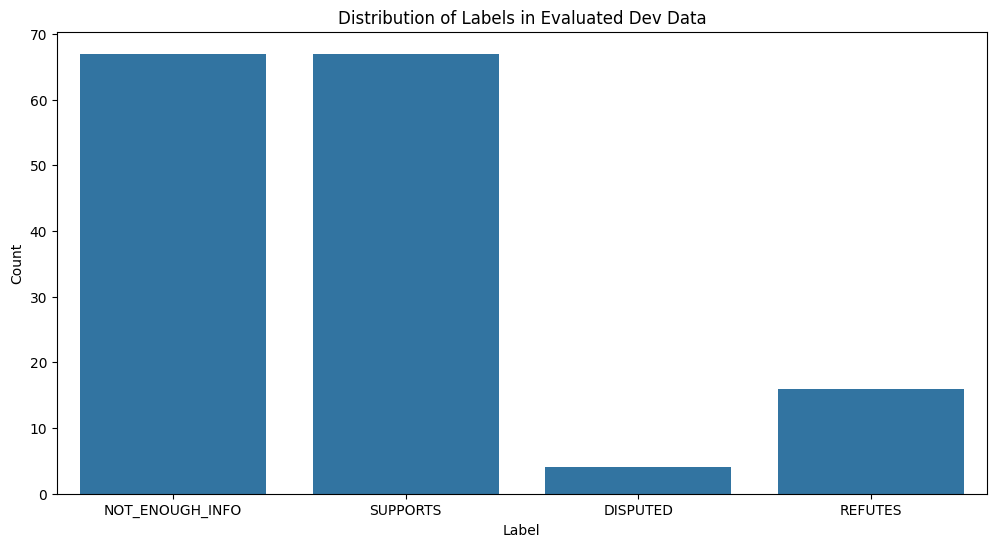


Class Distribution in Test Data:
claim_label
SUPPORTS           73
NOT_ENOUGH_INFO    71
REFUTES             7
DISPUTED            2
Name: count, dtype: int64


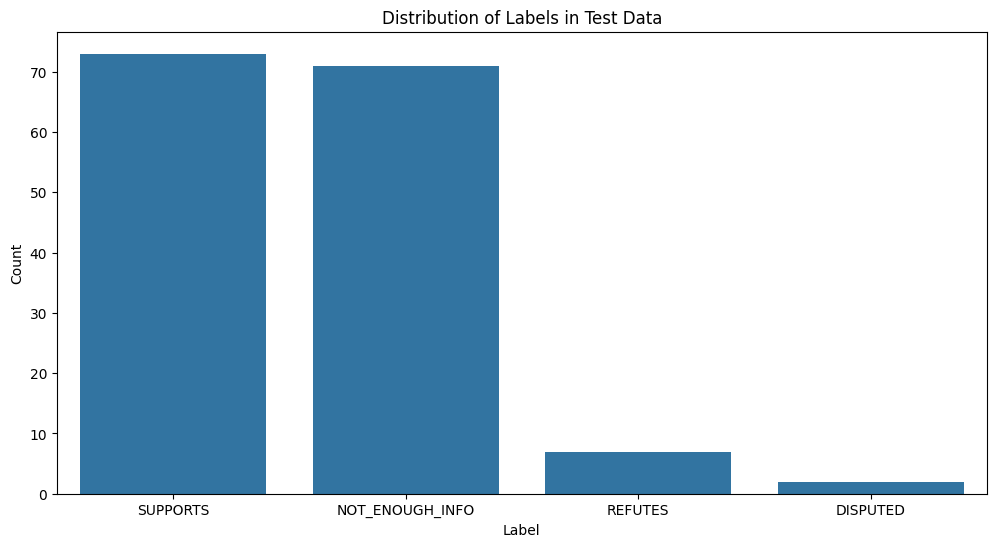

In [17]:
# Convert the dev_eval_output dictionary to a DataFrame
dev_eval_output_df = pd.DataFrame.from_dict(dev_eval_output, orient='index')
# Check if the 'claim_label' column exists in the DataFrame
if 'claim_label' in dev_eval_output_df.columns:
    print("\nClass Distribution in Evaluated Dev Data:")
    print(dev_eval_output_df['claim_label'].value_counts())


# Plot the distribution of labels in the evaluated dev data
plt.figure(figsize=(12, 6))
sns.countplot(x='claim_label', data=dev_eval_output_df)
plt.title('Distribution of Labels in Evaluated Dev Data')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Convert the test_output dictionary to a DataFrame
test_output_df = pd.DataFrame.from_dict(test_output, orient='index')
# Check if the 'claim_label' column exists in the DataFrame
if 'claim_label' in test_output_df.columns:
    print("\nClass Distribution in Test Data:")
    print(test_output_df['claim_label'].value_counts())


# Plot the distribution of labels in the evaluated test data
plt.figure(figsize=(12, 6))
sns.countplot(x='claim_label', data=test_output_df)
plt.title('Distribution of Labels in Test Data')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [18]:
import numpy as np

# Calculate accuracy
correct_predictions = (dev_eval_output_df['claim_label'] == dev_df['claim_label']).sum()
total_predictions = len(dev_eval_output_df)
accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.3961


In [19]:
from sklearn.metrics import classification_report

dev_true_labels = dev_df['claim_label'].tolist()
dev_pred_labels = dev_eval_output_df['claim_label'].tolist()

dev_report = classification_report(dev_true_labels, dev_pred_labels, output_dict=True)

dev_report_df = pd.DataFrame(dev_report).transpose()
# Rename the columns
dev_report_df = dev_report_df.rename(columns={'precision': 'Precision', 'recall': 'Recall', 'f1-score': 'F1-Score'})

# Drop the 'accuracy', 'weighted avg' and 'macro avg'
dev_report_df = dev_report_df.drop(['accuracy', 'macro avg', 'weighted avg'])
dev_report_df = dev_report_df.drop(columns = ['support'])
print("Per-Label Metrics - Dev:")
print(dev_report_df)

Per-Label Metrics - Dev:
                 Precision    Recall  F1-Score
DISPUTED          0.250000  0.055556  0.090909
NOT_ENOUGH_INFO   0.283582  0.463415  0.351852
REFUTES           0.375000  0.222222  0.279070
SUPPORTS          0.522388  0.514706  0.518519


In [20]:
# Sample output
# Rename columns for easier merging
dev_df_renamed = dev_df.rename(columns={"claim_label": "dev_claim_label"})

# Merge the dataframes on 'claim_text' to compare the labels and evidences
merged_df = pd.merge(dev_eval_output_df, dev_df_renamed, on='claim_text')

# Define a function to check if any evidence matches and to return matching evidence IDs
def get_matching_evidences(row):
    matching_evidences = [e for e in row['evidences_x'] if e in row['evidences_y']]
    return matching_evidences

# Find rows where any evidence matches and get the matching evidence IDs
merged_df['matching_evidences'] = merged_df.apply(get_matching_evidences, axis=1)
merged_df['evidence_matches'] = merged_df['matching_evidences'].apply(lambda x: len(x) > 0)

# Find rows where the labels are correctly predicted and evidence matches
correct_predictions = merged_df[(merged_df['claim_label'] == merged_df['dev_claim_label']) & merged_df['evidence_matches']]

# Function to get evidence texts from evidence IDs
def get_evidence_texts(evidence_ids, evidence_df):
    text = []
    if evidence_ids:
        for evidence_id in evidence_ids:
            text.append(evidence_df.loc[evidence_id]['evidence_text'])
    return text

# Display one example where the label is correctly predicted and evidence matches
if not correct_predictions.empty:
    correct_example = correct_predictions.iloc[0]
    matching_evidence_texts = get_evidence_texts(correct_example['matching_evidences'], evidence_df)
    print("Correctly predicted with matching evidence:")
    print(f"Claim ID: {correct_example.name}")  # Access the claim ID using the row's name attribute
    print(f"Claim Text: {correct_example['claim_text']}")
    print(f"Matching Evidence IDs: {correct_example['matching_evidences']}")
    print(f"Evidence Texts: {matching_evidence_texts}")
    # print(f"All predicted labels: { development_eval_df.loc[development_eval_df['claim_id'] == dev_eval_output_df.iloc[correct_example.name].name]['claim_label'].tolist()}")
    print(f"Label: {correct_example['claim_label']}")
else:
    print("No correctly predicted rows with matching evidence found")

Correctly predicted with matching evidence:
Claim ID: 12
Claim Text: Global warming is driving major melting on the surface of Greenland’s glaciers and is speeding up their travel into the sea.”
Matching Evidence IDs: ['evidence-1127398', 'evidence-1115033']
Evidence Texts: ['This acceleration is due mostly to human-caused global warming, which is driving thermal expansion of seawater and the melting of land-based ice sheets and glaciers.', 'Global warming could lead to an increase in freshwater in the northern oceans, by melting glaciers in Greenland, and by increasing precipitation, especially through Siberian rivers.']
Label: SUPPORTS


## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed*